<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Warning-:-error-with-dimensions-(except-first-image)" data-toc-modified-id="Warning-:-error-with-dimensions-(except-first-image)-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Warning : error with dimensions (except first image)</a></span></li></ul></div>

In [2]:
import matplotlib.pyplot as plt
from dh_segment.post_processing import boxes_detection, binarization, PAGE
import numpy as np

In [3]:
import pandas as pd
test_images =  pd.read_csv('/scratch/raphael/Richelieu/segmentation/test.csv', header=None)[0].values

In [4]:
import cv2

In [5]:
test_images

array(['/scratch/raphael/Richelieu/segmentation/JPEGImages/Annuaire-general-du-commerce_1848_bpt6k6315927h_490.jpg',
       '/scratch/raphael/Richelieu/segmentation/JPEGImages/Annuaire-general-du-commerce_1848_bpt6k6315927h_637.jpg',
       '/scratch/raphael/Richelieu/segmentation/JPEGImages/Annuaire-Didot-Bottin_1890_bpt6k97630871_380.jpg',
       '/scratch/raphael/Richelieu/segmentation/JPEGImages/Annuaire-Didot-Bottin_1862_bpt6k6333200c_367.jpg',
       '/scratch/raphael/Richelieu/segmentation/JPEGImages/Annuaire-general-du-commerce_1852_bpt6k63197984_91.jpg',
       '/scratch/raphael/Richelieu/segmentation/JPEGImages/Annuaire-Didot-Bottin_1873_bpt6k97645375_395.jpg',
       '/scratch/raphael/Richelieu/segmentation/JPEGImages/Annuaire-general-du-commerce_1845_bpt6k6292987t_607.jpg',
       '/scratch/raphael/Richelieu/segmentation/JPEGImages/Annuaire-Didot-Bottin_1878_bpt6k9692809v_531.jpg',
       '/scratch/raphael/Richelieu/segmentation/JPEGImages/Annuaire-Didot-Bottin_1874_bpt6k96

In [366]:
img = cv2.imread(test_images[0])
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
_, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU + cv2.THRESH_BINARY_INV)
kernel = np.ones((50,8),np.uint8)
dilation = cv2.dilate(thresh,kernel,iterations = 2)
# bin_image = (binarization.cleaning_binary(dilation)*255).astype(np.uint8)
edges = cv2.Canny(dilation,100,150,apertureSize = 3)
edges = cv2.Sobel(dilation, cv2.CV_8U,1,0,ksize=3)

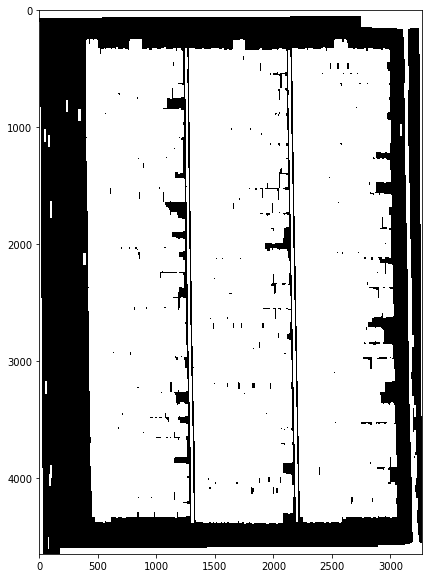

In [367]:
plt.figure(figsize=(10,10))
plt.imshow(cv2.cvtColor(dilation, cv2.COLOR_GRAY2BGR))

In [368]:
cnt, contours, _ = cv2.findContours(dilation, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

In [369]:
contours = [c for c in contours if cv2.contourArea(c) > 1000000]
cv2.boundingRect()

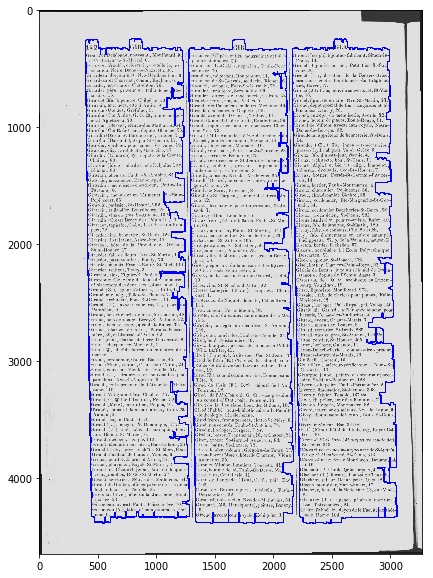

In [370]:
tmp = img.copy()
[cv2.drawContours(tmp, [c], -1, (255,0,0), 10) for c in contours]
plt.figure(figsize=(10,10))
plt.imshow(cv2.cvtColor(tmp, cv2.COLOR_BGR2RGB))

4


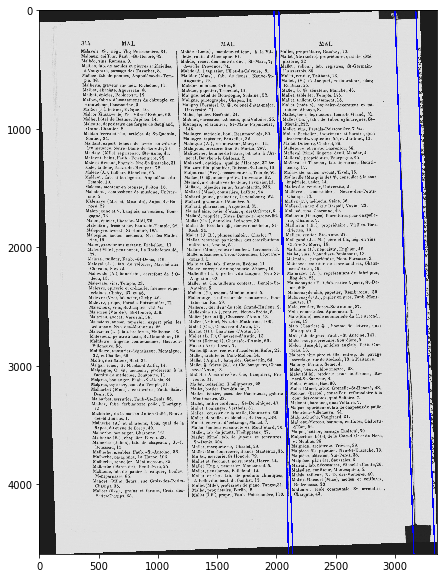

In [345]:
img = cv2.imread(test_images[19])
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
_, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU + cv2.THRESH_BINARY_INV)
kernel = np.ones((50,5),np.uint8)
dilation = cv2.dilate(thresh,kernel,iterations = 2)
# bin_image = (binarization.cleaning_binary(dilation)*255).astype(np.uint8)
edges = cv2.Canny(dilation,100,150,apertureSize = 3)
edges = cv2.Sobel(dilation, cv2.CV_8U,2,0,ksize=3)

tmp = img.copy()
lines = cv2.HoughLines(edges,1,np.pi/180,
                       600)
print(len(lines))
for line in lines:
    for rho,theta in line:
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a*rho
        y0 = b*rho
        x1 = int(x0 + 10000*(-b))
        y1 = int(y0 + 10000*(a))
        x2 = int(x0 - 10000*(-b))
        y2 = int(y0 - 10000*(a))

        cv2.line(tmp,(x1,y1),(x2,y2),(0,0,255),10)
plt.figure(figsize=(10,10))
plt.imshow(tmp);

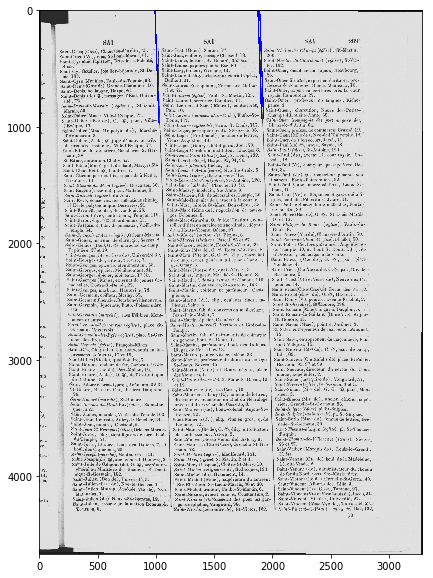

In [373]:
# DO NOT RUN
import tensorflow as tf
from dh_segment.loader import LoadedModel
from dh_segment.post_processing import boxes_detection, binarization, PAGE
from tqdm import tqdm_notebook as tqdm
import os

%env CUDA_VISIBLE_DEVICES=1
model_dir = '/scratch/raphael/Richelieu/segmentation/model/export/'
# model_dir = 'D:/USERS/rbarman/Documents/Notebooks/drouot_39-45/export'

prediction_data = {}

with tf.Session():  # Start a tensorflow session
        # Load the model
        m = LoadedModel(model_dir, predict_mode='filename')
        for filename in tqdm(test_images):
            basename = os.path.basename(filename).split('.')[0]
            prediction_outputs = m.predict(filename)
            probs = prediction_outputs['probs'][0]
            original_shape = prediction_outputs['original_shape']
            prediction_data[basename] = (probs, original_shape)
np.save('prediction_data.npy', prediction_data)

env: CUDA_VISIBLE_DEVICES=1
Loading /scratch/raphael/Richelieu/segmentation/model/export/1543498005
INFO:tensorflow:Restoring parameters from /scratch/raphael/Richelieu/segmentation/model/export/1543498005/variables/variables


In [5]:
prediction_data = np.load('prediction_data.npy').item()
len(prediction_data)

20

## Warning : error with dimensions (except first image)

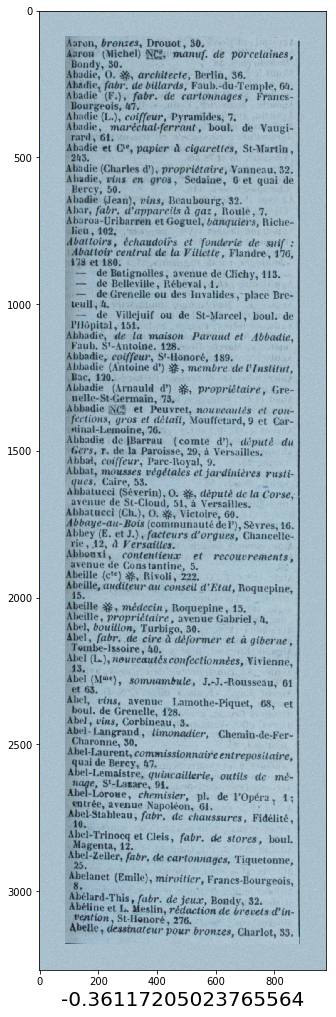

In [49]:
color_thresh = 550
for img_name in list(prediction_data.keys())[-2:-1]:
    image = cv2.imread('/scratch/raphael/Richelieu/segmentation/JPEGImages/%s.jpg'%img_name)

    tmp = image.copy()

    probs, original_shape = prediction_data[img_name]
    probs = cv2.resize(probs, tuple(original_shape[::-1]), interpolation=cv2.INTER_NEAREST)
    fig = plt.figure(figsize=(20,60))

    for i in range(1):
        mask = binarization.thresholding(probs[:,:,i], 0.9) # proba per pixel of belonging to class i (col i)

        _, contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        contour = sorted(contours, key=lambda c: cv2.contourArea(c), reverse=True)[0]
        rect = cv2.minAreaRect(contour)
        box = cv2.boxPoints(rect)
        box = np.int0(box)
        #cv2.drawContours(tmp,[box],0,(255,0,0),7)
        crop, angle = crop_minAreaRect(tmp, rect)
        
        # Construct the borders : first left and right of size (90 * height) and add bottom and top of size ((2*90+width) * 90)
        colors = np.unique(crop[:1].reshape(1*crop.shape[1], 3), axis=0)
        colors = colors[colors.sum(axis=1) > color_thresh]
        rand_idxs_l = np.random.choice(np.arange(len(colors)), crop.shape[0]*90) # left part sample
        rand_idxs_t = np.random.choice(np.arange(len(colors)), crop.shape[1]*90) # top part sample

        img_side = colors[rand_idxs_l].reshape(crop.shape[0], 90, 3)
        img_top = colors[rand_idxs_t].reshape(90, crop.shape[1], 3)
        # add 90-pixel-wide paddings on the sides of the top and bottom parts :
        img_top_corners = cv2.copyMakeBorder(img_top,0,0,90,90,cv2.BORDER_REFLECT)
       
        # Stack all the part (horizontally and then vertically):
        sides = np.concatenate((img_side, crop, img_side), axis=1)
        stacked_img = np.concatenate((img_top_corners, sides, img_top_corners), axis=0)
        #print('crop : ', crop.shape, ', img_side : ', img_side.shape, ', img_top_corners : ', img_top_corners.shape)
        ax = plt.subplot(3,3,i+1)
        plt.imshow(stacked_img)
        ax.set_xlabel(angle, fontsize = 20)

        # save one image per column : 
        filename = "images_crops_with_borders//file_%s_col%s.png"%(img_name,i+1)
        cv2.imwrite(filename, stacked_img)
        





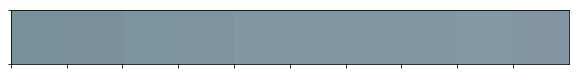

In [47]:
import seaborn as sns
sns.palplot([tuple([y/255 for y in x]) for x in colors[colors.sum(axis=1) > 500][:10]])

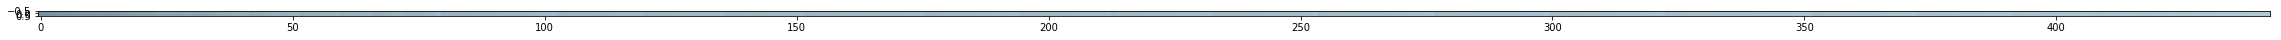

In [30]:
plt.figure(figsize=(40,40))
plt.imshow(colors.reshape(1, -1, 3))

In [41]:
clear_colors = colors[[i for i in colors if i.any() > 120]]
len(clear_colors)

0

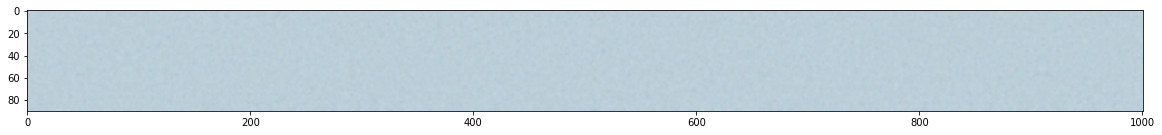

In [395]:
# Test with Gaussian Blur with kernel of size 5
plt.figure(figsize = (20,20))
blur = cv2.GaussianBlur(img_top,(5,5),0)

top_border_part = cv.copyMakeBorder(blur,0,0,90,90,cv.BORDER_REFLECT)

plt.imshow(top_border_part)



In [7]:
def crop_minAreaRect(img, rect):

    box = cv2.boxPoints(rect)
    box = np.int0(box)
    
    W = rect[1][0]
    H = rect[1][1]

    Xs = [i[0] for i in box]
    Ys = [i[1] for i in box]
    x1 = min(Xs)
    x2 = max(Xs)
    y1 = min(Ys)
    y2 = max(Ys)

    rotated = False
    angle = rect[2]
    angle_to_disp = angle
    if angle < -45:
        angle+=90
        rotated = True
    mult = 1 # area slightly larger
    center = (int((x1+x2)/2), int((y1+y2)/2))
    size = (int(mult*(x2-x1)),int(mult*(y2-y1)))

    M = cv2.getRotationMatrix2D((size[0]/2, size[1]/2), angle, 1.0)

    img_box = img.copy()
    cropped = cv2.getRectSubPix(img_box, size, center)    
    cropped = cv2.warpAffine(cropped, M, size)

    croppedW = W if not rotated else H 
    croppedH = H if not rotated else W

    croppedRotated = cv2.getRectSubPix(cropped, (int(croppedW*mult), int(croppedH*mult)), (size[0]/2, size[1]/2))
    
    return croppedRotated, angle_to_disp




In [163]:
# TEST
# now find the dominant color and add a contour 
plt.figure(figsize=(30,30))
img = crop.copy()
# find the dominant color
colors = get_dominant_color(img)
# add a border of this color. It enables a better detection of outlying letters
constant= cv2.copyMakeBorder(img,90,90,90,90,cv2.BORDER_CONSTANT,value=colors)

#plt.imshow(constant)


<Figure size 2160x2160 with 0 Axes>

In [162]:
# to get the dominant color (not used)
from sklearn.cluster import KMeans
from collections import Counter
import cv2 #for resizing image

def get_dominant_color(image, k=4, image_processing_size = (25, 25)):
    """
    takes an image as input
    returns the dominant color of the image as a list
    
    dominant color is found by running k means on the 
    pixels & returning the centroid of the largest cluster

    processing time is sped up by working with a smaller image; 
    this resizing can be done with the image_processing_size param 
    which takes a tuple of image dims as input

    >>> get_dominant_color(my_image, k=4, image_processing_size = (25, 25))
    [56.2423442, 34.0834233, 70.1234123]
    """
    #resize image if new dims provided
    if image_processing_size is not None:
        image = cv2.resize(image, image_processing_size, 
                            interpolation = cv2.INTER_AREA)
    
    #reshape the image to be a list of pixels
    image = image.reshape((image.shape[0] * image.shape[1], 3))

    #cluster and assign labels to the pixels 
    clt = KMeans(n_clusters = k)
    labels = clt.fit_predict(image)

    #count labels to find most popular
    label_counts = Counter(labels)

    #subset out most popular centroid
    dominant_color = clt.cluster_centers_[label_counts.most_common(1)[0][0]]

    return list(dominant_color)